# Quantitative Evaluation

This notebook provides the quantitative evaluation of the model's performance.


In [9]:
from PIL import Image, ImageDraw
from IPython.display import display

def draw_segmentation_mask(image_path, annotation_path):
    # Open the image
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)
    
    # Read the annotation file
    with open(annotation_path, 'r') as f:
        lines = f.readlines()
    
    # Define class names
    class_names = {0: 'bottle', 1: 'cup', 2: 'laptop'}
    
    # Define colors for each class
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]  # Red, Green, Blue
    
    for line in lines:
        line = line.strip().split()
        class_id = int(line[0])
        class_name = class_names[class_id]
        color = colors[class_id]
        
        # Convert YOLO format to image coordinates
        points = [float(x) for x in line[1:]]
        coordinates = [(points[i]*image.width, points[i+1]*image.height) for i in range(0, len(points), 2)]
        
        # Draw polygon for segmentation mask
        draw.polygon(coordinates, outline=color, fill=color)
    
    # Return the image
    return image

In [10]:
from PIL import Image, ImageDraw, ImageFont
import os
import random
from IPython.display import display

def draw_masks_and_bboxes(image_path, annotation_path, bbox_path, transparency=128, class_names={0: 'bottle', 1: 'cup', 2: 'computer'}, font_size=12):
    image = Image.open(image_path)
    mask_image = Image.new('RGBA', image.size)
    draw_mask = ImageDraw.Draw(mask_image)
    draw_bbox = ImageDraw.Draw(image)
    
    with open(annotation_path, 'r') as f:
        annotation_lines = f.readlines()
    
    with open(bbox_path, 'r') as f:
        bbox_lines = f.readlines()
    
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]
    
    for line in annotation_lines:
        line = line.strip().split()
        class_id = int(line[0])
        class_name = class_names[class_id]
        color = colors[class_id] + (transparency,)
        
        points = [float(x) for x in line[1:]]
        coordinates = [(points[i]*image.width, points[i+1]*image.height) for i in range(0, len(points), 2)]
        draw_mask.polygon(coordinates, outline=color, fill=color)
        
    for line in bbox_lines:
        line = line.strip().split()
        class_id = int(line[0])
        class_name = class_names[class_id]
        color = colors[class_id]
        
        x_center = float(line[1]) * image.width
        y_center = float(line[2]) * image.height
        width = float(line[3]) * image.width
        height = float(line[4]) * image.height
        x_min = x_center - width / 2
        y_min = y_center - height / 2
        x_max = x_center + width / 2
        y_max = y_center + height / 2
        
        draw_bbox.rectangle([x_min, y_min, x_max, y_max], outline=color)
        draw_bbox.text((x_min, y_min), class_name, fill=color) 

    masked_image = Image.alpha_composite(image.convert('RGBA'), mask_image)
    
    return masked_image, mask_image, image


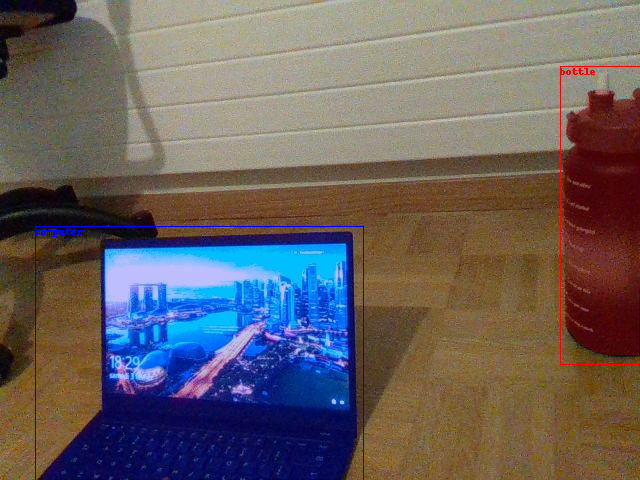

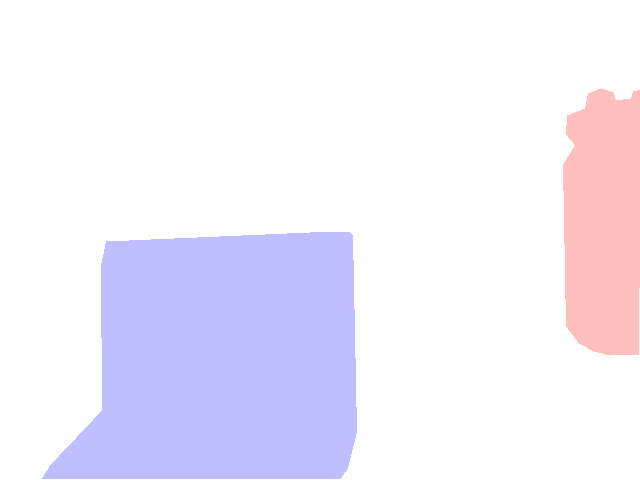

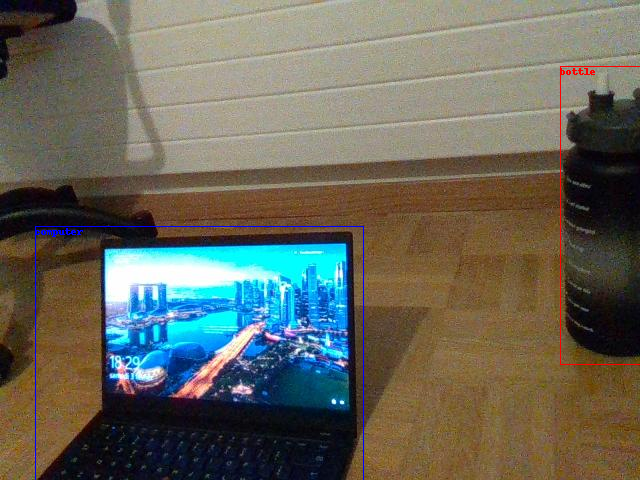

In [11]:
image_folder_path = 'quantitative_eval/valid/images/'
annotation_folder_path = 'quantitative_eval/valid/labels_seg/'
bbox_folder_path = 'quantitative_eval/valid/labels/'

random_image = random.choice(os.listdir(image_folder_path))
image_path = os.path.join(image_folder_path, random_image)

annotation_file = os.path.splitext(random_image)[0] + '.txt'
annotation_path = os.path.join(annotation_folder_path, annotation_file)
bbox_path = os.path.join(bbox_folder_path, annotation_file)

masked_image_with_bbox, mask_image, image_with_bbox = draw_masks_and_bboxes(image_path, annotation_path, bbox_path, transparency=64)

# Display images
display(masked_image_with_bbox)  # Image with mask and bounding boxes
display(mask_image)  # Mask only
display(image_with_bbox)  # Image with bounding boxes only

In [14]:
from ultralytics import YOLO
import os
import numpy as np

def calculate_iou(box1, box2):
    """
    Calculate IoU (Intersection over Union) between two bounding boxes.

    Args:
        box1 (list): Coordinates [x_min, y_min, x_max, y_max] of the first bounding box.
        box2 (list): Coordinates [x_min, y_min, x_max, y_max] of the second bounding box.

    Returns:
        float: Intersection over Union (IoU) value.
    """
    # Calculate coordinates of intersection rectangle
    x_min = max(box1[0], box2[0])
    y_min = max(box1[1], box2[1])
    x_max = min(box1[2], box2[2])
    y_max = min(box1[3], box2[3])

    # Calculate area of intersection rectangle
    intersection_area = max(0, x_max - x_min) * max(0, y_max - y_min)

    # Calculate area of union of two boxes
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - intersection_area

    # Calculate IoU
    iou = intersection_area / union_area if union_area > 0 else 0

    return iou

# Load YOLO model
model = YOLO(f'yolo_train/runs/detect/train/weights/best.pt')

# Define paths
image_folder_path = '/home/saf/Downloads/quantitative_eval/valid/images'
label_folder_path = '/home/saf/Downloads/quantitative_eval/valid/labels'

# Initialize a list to store IoU scores
iou_scores = []

# Iterate over images
for image_file in os.listdir(image_folder_path):
    # Load image
    image_path = os.path.join(image_folder_path, image_file)
    image = Image.open(image_path)
    
    # Run YOLO model
    results = model.predict(source=image_path, conf=0.5)
    predicted_boxes = results[0].boxes.xyxy.cpu().numpy()
    
    # Load ground truth bounding boxes
    label_file = os.path.splitext(image_file)[0] + '.txt'
    label_path = os.path.join(label_folder_path, label_file)
    with open(label_path, 'r') as f:
        ground_truth_boxes = []
        for line in f:
            line = line.strip().split()
            class_id = int(line[0])
            x_center = float(line[1]) * image.width
            y_center = float(line[2]) * image.height
            width = float(line[3]) * image.width
            height = float(line[4]) * image.height
            x_min = x_center - width / 2
            y_min = y_center - height / 2
            x_max = x_center + width / 2
            y_max = y_center + height / 2
            ground_truth_boxes.append([x_min, y_min, x_max, y_max])
        ground_truth_boxes = np.array(ground_truth_boxes)
    
    # Calculate IoU for each predicted bounding box
    for predicted_box in predicted_boxes:
        iou_scores.append(max([calculate_iou(predicted_box[:4], gt_box) for gt_box in ground_truth_boxes]))

# Compute mean IoU
mean_iou = np.mean(iou_scores)

# Print or log the mean IoU
print("Mean IoU:", mean_iou)



image 1/1 /home/saf/Downloads/quantitative_eval/valid/images/1706981255889.jpg: 480x640 1 bottle, 1 computer, 1 cup, 7.6ms
Speed: 1.1ms preprocess, 7.6ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/saf/Downloads/quantitative_eval/valid/images/1706981367611.jpg: 480x640 1 bottle, 1 computer, 6.3ms
Speed: 0.9ms preprocess, 6.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/saf/Downloads/quantitative_eval/valid/images/1706981325539.jpg: 480x640 1 bottle, 6.3ms
Speed: 0.9ms preprocess, 6.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/saf/Downloads/quantitative_eval/valid/images/1706981226688.jpg: 480x640 1 bottle, 1 computer, 1 cup, 6.4ms
Speed: 1.0ms preprocess, 6.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/saf/Downloads/quantitative_eval/valid/images/1706981230609.jpg: 480x640 1 bottle, 1 computer, 2 cups, 5.9ms
Speed: 0.9ms preproce

Mean IoU: 0.9521295913023426


## FastSAM

Let's now check the result of FastSAM.
First, you need to download the FastSAM in home folder. Follow the instructions as mentionned in [FastSAM_Github](https://github.com/CASIA-IVA-Lab/FastSAM) repository.

Or run the following cell

In [15]:
import os

# Define the folder name
folder_name = "FastSAM"

# Check if the folder already exists
if os.path.exists(folder_name):
    print(f"The folder '{folder_name}' already exists. Skipping git clone.")
else:
    # Clone the repo
    !git clone https://github.com/CASIA-IVA-Lab/FastSAM.git
    print(f"Repository cloned successfully into the '{folder_name}' folder.")


The folder 'FastSAM' already exists. Skipping git clone.


In [ ]:
import torch
from FastSAM.fastsam import FastSAM, FastSAMPrompt
from ultralytics import YOLO
from PIL import Image

# Load YOLOv8 model
yolo_model = YOLO('yolo_train/runs/detect/train/weights/best.pt')

# Load FastSAM model
fastsam_model = FastSAM('FastSAM-s.pt')

DEVICE = torch.device(
    "cuda:0"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(DEVICE)

yolo_results = yolo_model.predict(source=image_path, conf=0.50)
predicted_boxes = yolo_results[0].boxes.xyxy.cpu().numpy()

color_image = Image.open('/home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/images/1706981199297.jpg')

with open('/home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/labels_seg/1706981199297.txt', 'r') as f:
        annotation_lines = f.readlines()

bounding_boxes = [list(map(int, box[:4])) for box in predicted_boxes]

fastsam_results = fastsam_model(color_image, device=DEVICE, retina_masks=True, imgsz=640)

prompt_process = FastSAMPrompt(color_image, fastsam_results, device=DEVICE)
ann = prompt_process.box_prompt(bboxes=bounding_boxes)
img_with_annotations = prompt_process.plot_to_result(annotations=ann)

Pil_img_with_annotations = Image.fromarray(img_with_annotations)

display(Pil_img_with_annotations)

draw_mask = ImageDraw.Draw(Pil_img_with_annotations)

for line in annotation_lines:
        line = line.strip().split()
        class_id = int(line[0])
        
        points = [float(x) for x in line[1:]]
        coordinates = [(points[i]*image.width, points[i+1]*image.height) for i in range(0, len(points), 2)]
        draw_mask.polygon(coordinates, outline='red', fill='red')
        


In [87]:
bounding_boxes

[[116, 224, 400, 384], [564, 123, 640, 383]]

In [85]:
import torch
from FastSAM.fastsam import FastSAM, FastSAMPrompt
from ultralytics import YOLO
from PIL import Image

# Load YOLOv8 model
yolo_model = YOLO('yolo_train/runs/detect/train/weights/best.pt')

# Load FastSAM model
fastsam_model = FastSAM('FastSAM-s.pt')

DEVICE = torch.device(
    "cuda:0"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(DEVICE)

yolo_results = yolo_model.predict(source=image_path, conf=0.50)
predicted_boxes = yolo_results[0].boxes.xyxy.cpu().numpy()

color_image = Image.open('/home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/images/1706981199297.jpg')

with open('/home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/labels_seg/1706981199297.txt', 'r') as f:
        annotation_lines = f.readlines()

bounding_boxes = [list(map(int, box[:4])) for box in predicted_boxes]

fastsam_results = fastsam_model(color_image, device=DEVICE, retina_masks=True, imgsz=640)

prompt_process = FastSAMPrompt(color_image, fastsam_results, device=DEVICE)
ann = prompt_process.box_prompt(bboxes=bounding_boxes)
gray_image = np.array(ann[0] * 255, dtype=np.uint8)  # Multiply by 255 to convert from [0, 1] to [0, 255]

# Create a PIL image from the grayscale image
pil_image = Image.fromarray(gray_image, mode='L')



image 1/1 /home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/images/1706981339683.jpg: 480x640 1 bottle, 1 computer, 7.3ms
Speed: 1.1ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


cuda:0



0: 480x640 9 objects, 11.2ms
Speed: 0.9ms preprocess, 11.2ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 640)


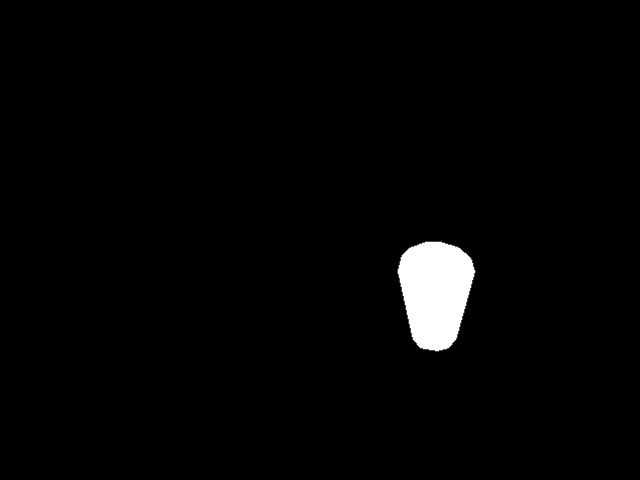

In [25]:
from PIL import Image, ImageDraw

# Create a new binary mask image
mask_image = Image.new('L', color_image.size, 0)

# Create a drawing object
draw_mask = ImageDraw.Draw(mask_image)

with open('/home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/labels_seg/1706981199297.txt', 'r') as f:
    annotation_lines = f.readlines()

gt_mask = []

for line in annotation_lines:
    line = line.strip().split()
    class_id = int(line[0])
    
    points = [float(x) for x in line[1:]]
    coordinates = [(points[i]*color_image.width, points[i+1]*color_image.height) for i in range(0, len(points), 2)]
    gt_mask.append(coordinates)
    
draw_mask.polygon(gt_mask[0], outline='red', fill='white')  # Fill with white to create binary mask

# Display the binary mask image
display(mask_image)


In [28]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score

def calculate_metrics(mask1, mask2, thresholds=[0.5, 0.95]):
    # Convert masks to numpy arrays
    mask1_array = np.array(mask1)
    mask2_array = np.array(mask2)
    
    # Jaccard index (IoU)
    mask1_nonzero_coords = np.transpose(np.nonzero(mask1_array))
    mask2_nonzero_coords = np.transpose(np.nonzero(mask2_array))
    intersection = len(np.intersect1d(mask1_nonzero_coords, mask2_nonzero_coords))
    union = len(np.union1d(mask1_nonzero_coords, mask2_nonzero_coords))
    iou = intersection / union if union > 0 else 0
    
    # Dice Coefficient
    intersection_dice = np.logical_and(mask1_array, mask2_array)
    union_dice = np.logical_or(mask1_array, mask2_array)
    dice = (2 * np.sum(intersection_dice)) / (np.sum(union_dice) + np.sum(intersection_dice))
    
    # Area under the ROC curve (AUC)
    mask1_flat = mask1_array.flatten()
    mask2_flat = mask2_array.flatten()
    auc = roc_auc_score(mask1_flat, mask2_flat)
    
    # Precision
    true_positives = np.logical_and(mask1_array, mask2_array).sum()
    false_positives = np.logical_and(mask1_array, np.logical_not(mask2_array)).sum()
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    
    # Recall
    false_negatives = np.logical_and(np.logical_not(mask1_array), mask2_array).sum()
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    
    # F1 Score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    
    # Pixel-wise Accuracy
    pixel_accuracy = accuracy_score(mask1_flat, mask2_flat)

    # Intersection over Union at Thresholds (IoU@T)
    iou_at_thresholds = {}
    for threshold in thresholds:
        mask1_binary = (mask1_array > threshold).astype(np.uint8)
        mask2_binary = (mask2_array > threshold).astype(np.uint8)
        intersection_binary = np.logical_and(mask1_binary, mask2_binary).sum()
        union_binary = np.logical_or(mask1_binary, mask2_binary).sum()
        iou_at_thresholds[f"IoU@{threshold}"] = intersection_binary / union_binary if union_binary > 0 else 0


    # Store metrics in a dictionary
    metrics = {
        "Jaccard Index (IoU)": iou,
        "Dice Coefficient": dice,
        "AUC": auc,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1_score,
        "Pixel Accuracy": pixel_accuracy,
        **iou_at_thresholds
    }
    
    return metrics


image 1/1 /home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/images/1706981339683.jpg: 480x640 1 bottle, 1 computer, 7.7ms
Speed: 5.4ms preprocess, 7.7ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 23 objects, 9.2ms
Speed: 1.1ms preprocess, 9.2ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)


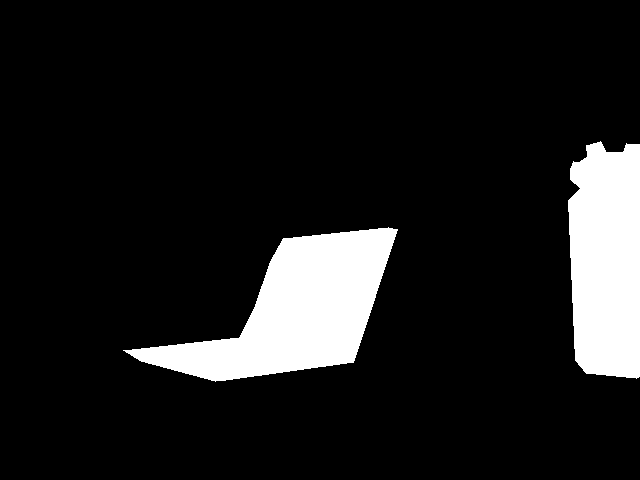

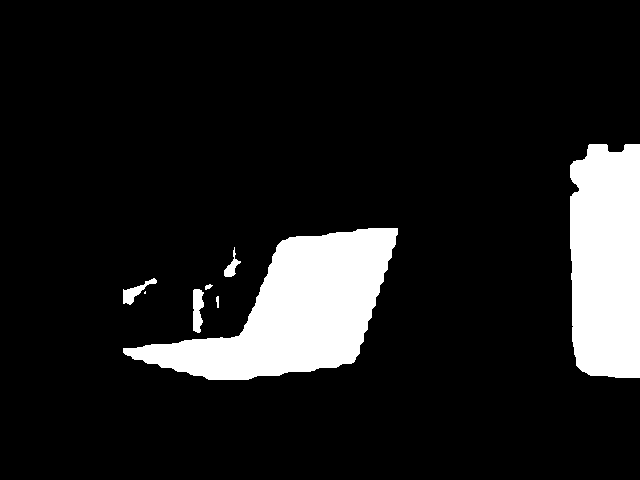

In [84]:
import numpy as np
from PIL import Image, ImageDraw

# Load your image and mask creation code
image_path = '/home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/images/1706981339683.jpg'
color_image = Image.open(image_path)

# Create ground truth mask
ground_truth_mask = Image.new('L', color_image.size, 0)
draw_mask = ImageDraw.Draw(ground_truth_mask)

annot_file = '/home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/labels_seg/1706981339683.txt'

with open(annot_file, 'r') as f:
    annotation_lines = f.readlines()

gt_mask = []

for line in annotation_lines:
    line = line.strip().split()
    class_id = int(line[0])
    
    points = [float(x) for x in line[1:]]
    coordinates = [(points[i]*color_image.width, points[i+1]*color_image.height) for i in range(0, len(points), 2)]
    gt_mask.append(coordinates)
    
for mask_coords in gt_mask:
    draw_mask.polygon(mask_coords, outline='white', fill='white')  # Fill with white to create binary mask

# Create predicted mask
predicted_mask = Image.new('L', color_image.size, 0)
draw_predicted_mask = ImageDraw.Draw(predicted_mask)

# Print the predicted boxes to check if there are any
yolo_results = yolo_model.predict(source=image_path, conf=0.50)
predicted_boxes = yolo_results[0].boxes.xyxy.cpu().numpy()

bounding_boxes = [list(map(int, box[:4])) for box in predicted_boxes]
fastsam_results = fastsam_model(color_image, device=DEVICE, retina_masks=True, imgsz=640)
prompt_process = FastSAMPrompt(color_image, fastsam_results, device=DEVICE)
ann = prompt_process.box_prompt(bboxes=bounding_boxes)

combined_mask = Image.new('L', color_image.size, 0)

# Loop over each mask in ann and draw it on the combined mask image
for mask_coords in ann:
    mask_image = np.array(mask_coords * 255, dtype=np.uint8)
    combined_mask = np.maximum(combined_mask, mask_image)

# Create a PIL image from the combined mask array
combined_mask = Image.fromarray(combined_mask, mode='L')

# Display the ground truth and predicted masks
display(ground_truth_mask, combined_mask)


In [30]:
metr = calculate_metrics(ground_truth_mask, combined_mask)
metr

{'Jaccard Index (IoU)': 0.9942363112391931,
 'Dice Coefficient': 0.9698249764147623,
 'AUC': 0.9932732077295884,
 'Precision': 0.9935949221004039,
 'Recall': 0.9471657636348635,
 'F1 Score': 0.9698249764147623,
 'Pixel Accuracy': 0.9930240885416667,
 'IoU@0.5': 0.9414176758426506,
 'IoU@0.95': 0.9414176758426506}

In [31]:
import numpy as np
from PIL import Image, ImageDraw

def create_masks(image_path, annot_file):
    # Load your image
    color_image = Image.open(image_path)

    # Create ground truth mask
    ground_truth_mask = Image.new('L', color_image.size, 0)
    draw_mask = ImageDraw.Draw(ground_truth_mask)

    with open(annot_file, 'r') as f:
        annotation_lines = f.readlines()

    gt_mask = []

    for line in annotation_lines:
        line = line.strip().split()
        class_id = int(line[0])

        points = [float(x) for x in line[1:]]
        coordinates = [(points[i] * color_image.width, points[i + 1] * color_image.height) for i in
                       range(0, len(points), 2)]
        gt_mask.append(coordinates)

    for mask_coords in gt_mask:
        draw_mask.polygon(mask_coords, outline='white', fill='white')  # Fill with white to create binary mask

    predicted_mask = Image.new('L', color_image.size, 0)
    draw_predicted_mask = ImageDraw.Draw(predicted_mask)

    yolo_results = yolo_model.predict(source=image_path, conf=0.50)
    predicted_boxes = yolo_results[0].boxes.xyxy.cpu().numpy()

    bounding_boxes = [list(map(int, box[:4])) for box in predicted_boxes]
    fastsam_results = fastsam_model(color_image, device=DEVICE, retina_masks=True, imgsz=640)
    prompt_process = FastSAMPrompt(color_image, fastsam_results, device=DEVICE)
    ann = prompt_process.box_prompt(bboxes=bounding_boxes)

    combined_mask = Image.new('L', color_image.size, 0)

    # Loop over each mask in ann and draw it on the combined mask image
    for mask_coords in ann:
        mask_image = np.array(mask_coords * 255, dtype=np.uint8)
        combined_mask = np.maximum(combined_mask, mask_image)

    combined_mask = Image.fromarray(combined_mask, mode='L')

    return ground_truth_mask, combined_mask

image_path = '/home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/images/1706981377684.jpg'
annot_file = '/home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/labels_seg/1706981377684.txt'

ground_truth_mask, combined_mask = create_masks(image_path, annot_file)
calculate_metrics(ground_truth_mask, combined_mask)


image 1/1 /home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/images/1706981377684.jpg: 480x640 1 bottle, 1 computer, 5.5ms
Speed: 0.9ms preprocess, 5.5ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 8 objects, 13.7ms
Speed: 1.6ms preprocess, 13.7ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


{'Jaccard Index (IoU)': 1.0,
 'Dice Coefficient': 0.9864732920747461,
 'AUC': 0.9893640544955485,
 'Precision': 0.9970167607943159,
 'Recall': 0.9761504845710208,
 'F1 Score': 0.9864732920747462,
 'Pixel Accuracy': 0.9882747395833333,
 'IoU@0.5': 0.9733076438549039,
 'IoU@0.95': 0.9733076438549039}

In [33]:
import os
import matplotlib.pyplot as plt

# Directories
images_dir = '/home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/images/'
annotations_dir = '/home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/labels_seg/'

# Lists to store metrics for all images
iou_list = []
dice_list = []
auc_list = []
jaccard_list = []
precision_list = []
recall_list = []
f1_list = []
pixel_accuracy_list = []

# List image files
image_files = os.listdir(images_dir)
image_files.sort()  # Sorting for consistency

# List annotation files
annotation_files = os.listdir(annotations_dir)
annotation_files.sort()  # Sorting for consistency

# Ensure both directories have the same number of files
assert len(image_files) == len(annotation_files), "Number of images and annotations do not match"

# Iterate over each image and annotation file
for image_file, annotation_file in zip(image_files, annotation_files):
    # Image and annotation paths
    image_path = os.path.join(images_dir, image_file)
    annotation_path = os.path.join(annotations_dir, annotation_file)
    
    # Create masks
    ground_truth_mask, combined_mask = create_masks(image_path, annotation_path)
    
    # Calculate metrics
    metrics = calculate_metrics(ground_truth_mask, combined_mask)
    
    print(metrics)
    print('--------------------')
    iou_list.append(metrics["Jaccard Index (IoU)"])
    dice_list.append(metrics["Dice Coefficient"])
    auc_list.append(metrics["AUC"])
    precision_list.append(metrics["Precision"])
    recall_list.append(metrics["Recall"])
    f1_list.append(metrics["F1 Score"])
    pixel_accuracy_list.append(metrics["Pixel Accuracy"])

mean_metrics = {
    "Jaccard Index (IoU)": np.mean(iou_list),
    "Dice Coefficient": np.mean(dice_list),
    "AUC": np.mean(auc_list),
    "Precision": np.mean(precision_list),
    "Recall": np.mean(recall_list),
    "F1 Score": np.mean(f1_list),
    "Pixel Accuracy": np.mean(pixel_accuracy_list),
}
std_metrics = {
    "Jaccard Index (IoU)": np.std(iou_list),
    "Dice Coefficient": np.std(dice_list),
    "AUC": np.std(auc_list),
    "Precision": np.std(precision_list),
    "Recall": np.std(recall_list),
    "F1 Score": np.std(f1_list),
    "Pixel Accuracy": np.std(pixel_accuracy_list),
}

print("Overall Mean Metrics:")
for metric, value in mean_metrics.items():
    print(metric + ":", value)
print("\nOverall Standard Deviation Metrics:")
for metric, value in std_metrics.items():
    print(metric + ":", value)





image 1/1 /home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/images/1706981199297.jpg: 480x640 1 bottle, 2 cups, 10.8ms
Speed: 18.3ms preprocess, 10.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 9 objects, 8.6ms
Speed: 1.4ms preprocess, 8.6ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/images/1706981219314.jpg: 480x640 1 bottle, 1 computer, 2 cups, 8.4ms
Speed: 1.8ms preprocess, 8.4ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 17 objects, 7.9ms
Speed: 1.0ms preprocess, 7.9ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/images/1706981222961.jpg: 480x640 1 bottle, 1 computer, 1 cup, 6.0ms
Speed: 0.9ms preprocess, 6.0ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 10 objects, 7.4

{'Jaccard Index (IoU)': 0.9805013927576601, 'Dice Coefficient': 0.9787620199961791, 'AUC': 0.9933660333074043, 'Precision': 0.9904942965779467, 'Recall': 0.9673044244445843, 'F1 Score': 0.9787620199961792, 'Pixel Accuracy': 0.9956575520833333, 'IoU@0.5': 0.9584073831571727, 'IoU@0.95': 0.9584073831571727}
--------------------
{'Jaccard Index (IoU)': 0.9933110367892977, 'Dice Coefficient': 0.9856871009427429, 'AUC': 0.9924330063422705, 'Precision': 0.9948270928261683, 'Recall': 0.9767135277654712, 'F1 Score': 0.9856871009427429, 'Pixel Accuracy': 0.991455078125, 'IoU@0.5': 0.971778138539774, 'IoU@0.95': 0.971778138539774}
--------------------



image 1/1 /home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/images/1706981226688.jpg: 480x640 1 bottle, 1 computer, 1 cup, 5.9ms
Speed: 1.2ms preprocess, 5.9ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 9 objects, 7.7ms
Speed: 0.8ms preprocess, 7.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/images/1706981230609.jpg: 480x640 1 bottle, 1 computer, 2 cups, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 11 objects, 7.5ms
Speed: 1.1ms preprocess, 7.5ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


{'Jaccard Index (IoU)': 0.9984, 'Dice Coefficient': 0.985587023435337, 'AUC': 0.991777228719349, 'Precision': 0.9928144891397074, 'Recall': 0.978464025869038, 'F1 Score': 0.9855870234353371, 'Pixel Accuracy': 0.991357421875, 'IoU@0.5': 0.9715836116105832, 'IoU@0.95': 0.9715836116105832}
--------------------
{'Jaccard Index (IoU)': 0.9101307189542484, 'Dice Coefficient': 0.8607605177993527, 'AUC': 0.8801077835708132, 'Precision': 0.7675334178441496, 'Recall': 0.9797660864874821, 'F1 Score': 0.8607605177993528, 'Pixel Accuracy': 0.9215690104166666, 'IoU@0.5': 0.7555571337262978, 'IoU@0.95': 0.7555571337262978}
--------------------



image 1/1 /home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/images/1706981237121.jpg: 480x640 1 bottle, 1 computer, 1 cup, 5.4ms
Speed: 1.0ms preprocess, 5.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 12 objects, 7.2ms
Speed: 1.4ms preprocess, 7.2ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/images/1706981239618.jpg: 480x640 1 bottle, 1 computer, 2 cups, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 14 objects, 8.3ms
Speed: 0.8ms preprocess, 8.3ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


{'Jaccard Index (IoU)': 1.0, 'Dice Coefficient': 0.9854774025841961, 'AUC': 0.9914874721735714, 'Precision': 0.9892939630201488, 'Recall': 0.9816901765137893, 'F1 Score': 0.985477402584196, 'Pixel Accuracy': 0.9925618489583333, 'IoU@0.5': 0.9713705787277762, 'IoU@0.95': 0.9713705787277762}
--------------------
{'Jaccard Index (IoU)': 0.9952755905511811, 'Dice Coefficient': 0.9664394405265018, 'AUC': 0.9853006810101661, 'Precision': 0.989192591501386, 'Recall': 0.9447094785578165, 'F1 Score': 0.9664394405265017, 'Pixel Accuracy': 0.98330078125, 'IoU@0.5': 0.9350583588626984, 'IoU@0.95': 0.9350583588626984}
--------------------



image 1/1 /home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/images/1706981242729.jpg: 480x640 1 bottle, 2 cups, 6.1ms
Speed: 1.0ms preprocess, 6.1ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 11 objects, 10.9ms
Speed: 1.2ms preprocess, 10.9ms inference, 3.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/images/1706981247417.jpg: 480x640 1 bottle, 1 cup, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 15 objects, 7.2ms
Speed: 0.8ms preprocess, 7.2ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)


{'Jaccard Index (IoU)': 1.0, 'Dice Coefficient': 0.9849720563118374, 'AUC': 0.9887500946285347, 'Precision': 0.9843353903022836, 'Recall': 0.9856095464428376, 'F1 Score': 0.9849720563118375, 'Pixel Accuracy': 0.9903190104166667, 'IoU@0.5': 0.9703891035087021, 'IoU@0.95': 0.9703891035087021}
--------------------
{'Jaccard Index (IoU)': 0.9885321100917431, 'Dice Coefficient': 0.9778753072873988, 'AUC': 0.9871113678618352, 'Precision': 0.9770475423940496, 'Recall': 0.9787044759521824, 'F1 Score': 0.9778753072873987, 'Pixel Accuracy': 0.994814453125, 'IoU@0.5': 0.9567084273174443, 'IoU@0.95': 0.9567084273174443}
--------------------



image 1/1 /home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/images/1706981250473.jpg: 480x640 1 bottle, 1 computer, 2 cups, 5.9ms
Speed: 0.9ms preprocess, 5.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 17 objects, 7.4ms
Speed: 1.0ms preprocess, 7.4ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/images/1706981255889.jpg: 480x640 1 bottle, 1 computer, 1 cup, 6.1ms
Speed: 0.9ms preprocess, 6.1ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 8 objects, 6.9ms
Speed: 0.8ms preprocess, 6.9ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)


{'Jaccard Index (IoU)': 0.990632318501171, 'Dice Coefficient': 0.9864249704447555, 'AUC': 0.9948087769478665, 'Precision': 0.992263320484431, 'Recall': 0.980654922727764, 'F1 Score': 0.9864249704447554, 'Pixel Accuracy': 0.996748046875, 'IoU@0.5': 0.9732135675023461, 'IoU@0.95': 0.9732135675023461}
--------------------
{'Jaccard Index (IoU)': 0.9968701095461658, 'Dice Coefficient': 0.9828089986840833, 'AUC': 0.9859154677568669, 'Precision': 0.9824826844193396, 'Recall': 0.9831355297798787, 'F1 Score': 0.9828089986840832, 'Pixel Accuracy': 0.986689453125, 'IoU@0.5': 0.9661990692137915, 'IoU@0.95': 0.9661990692137915}
--------------------



image 1/1 /home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/images/1706981269930.jpg: 480x640 1 bottle, 1 computer, 1 cup, 6.1ms
Speed: 1.2ms preprocess, 6.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 10 objects, 7.2ms
Speed: 0.9ms preprocess, 7.2ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/images/1706981274626.jpg: 480x640 1 bottle, 1 computer, 1 cup, 6.3ms
Speed: 1.0ms preprocess, 6.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 14 objects, 9.1ms
Speed: 1.2ms preprocess, 9.1ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


{'Jaccard Index (IoU)': 0.9948805460750854, 'Dice Coefficient': 0.9830048416712454, 'AUC': 0.9892181186319631, 'Precision': 0.9924049192607834, 'Recall': 0.973781168589505, 'F1 Score': 0.9830048416712454, 'Pixel Accuracy': 0.9882194010416666, 'IoU@0.5': 0.9665777006122958, 'IoU@0.95': 0.9665777006122958}
--------------------
{'Jaccard Index (IoU)': 1.0, 'Dice Coefficient': 0.971081570155902, 'AUC': 0.9816968903388293, 'Precision': 0.9941041306709891, 'Recall': 0.9491012363314797, 'F1 Score': 0.9710815701559021, 'Pixel Accuracy': 0.978359375, 'IoU@0.5': 0.9437886833293875, 'IoU@0.95': 0.9437886833293875}
--------------------



image 1/1 /home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/images/1706981283202.jpg: 480x640 1 bottle, 1 computer, 1 cup, 5.6ms
Speed: 0.9ms preprocess, 5.6ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 16 objects, 7.4ms
Speed: 1.0ms preprocess, 7.4ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/images/1706981285354.jpg: 480x640 1 bottle, 1 computer, 2 cups, 5.5ms
Speed: 0.9ms preprocess, 5.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 16 objects, 6.9ms
Speed: 0.8ms preprocess, 6.9ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


{'Jaccard Index (IoU)': 0.9878260869565217, 'Dice Coefficient': 0.9841069567696139, 'AUC': 0.9897763667184875, 'Precision': 0.992515788481478, 'Recall': 0.9758394113231328, 'F1 Score': 0.9841069567696139, 'Pixel Accuracy': 0.9889290364583333, 'IoU@0.5': 0.968711187981269, 'IoU@0.95': 0.968711187981269}
--------------------
{'Jaccard Index (IoU)': 0.8800705467372134, 'Dice Coefficient': 0.9318781358299281, 'AUC': 0.9529332465030607, 'Precision': 0.9126646403242148, 'Recall': 0.9519179964070591, 'F1 Score': 0.9318781358299281, 'Pixel Accuracy': 0.9828515625, 'IoU@0.5': 0.8724455205811138, 'IoU@0.95': 0.8724455205811138}
--------------------



image 1/1 /home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/images/1706981289922.jpg: 480x640 1 bottle, 1 computer, 2 cups, 6.2ms
Speed: 0.9ms preprocess, 6.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 8 objects, 8.5ms
Speed: 0.9ms preprocess, 8.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/images/1706981292306.jpg: 480x640 1 bottle, 1 computer, 2 cups, 5.9ms
Speed: 1.2ms preprocess, 5.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 11 objects, 6.8ms
Speed: 0.9ms preprocess, 6.8ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


{'Jaccard Index (IoU)': 0.9940476190476191, 'Dice Coefficient': 0.9801109252907774, 'AUC': 0.9901079290893086, 'Precision': 0.9854835645069352, 'Recall': 0.9747965493262165, 'F1 Score': 0.9801109252907773, 'Pixel Accuracy': 0.9931477864583333, 'IoU@0.5': 0.960997572770562, 'IoU@0.95': 0.960997572770562}
--------------------
{'Jaccard Index (IoU)': 0.9619651347068146, 'Dice Coefficient': 0.9691816516177164, 'AUC': 0.9817429151743029, 'Precision': 0.9818169693467002, 'Recall': 0.9568674176776429, 'F1 Score': 0.9691816516177164, 'Pixel Accuracy': 0.9817122395833333, 'IoU@0.5': 0.9402060538975691, 'IoU@0.95': 0.9402060538975691}
--------------------



image 1/1 /home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/images/1706981306162.jpg: 480x640 1 bottle, 1 computer, 5.4ms
Speed: 1.2ms preprocess, 5.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 8 objects, 8.5ms
Speed: 0.9ms preprocess, 8.5ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/images/1706981311443.jpg: 480x640 1 bottle, 1 computer, 6.0ms
Speed: 1.0ms preprocess, 6.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 6 objects, 8.7ms
Speed: 0.9ms preprocess, 8.7ms inference, 2.7ms postprocess per image at shape (1, 3, 640, 640)


{'Jaccard Index (IoU)': 0.9838383838383838, 'Dice Coefficient': 0.9714447605444265, 'AUC': 0.9863845037060873, 'Precision': 0.9784790259678493, 'Recall': 0.9645109116054476, 'F1 Score': 0.9714447605444264, 'Pixel Accuracy': 0.9921256510416666, 'IoU@0.5': 0.9444750493504108, 'IoU@0.95': 0.9444750493504108}
--------------------
{'Jaccard Index (IoU)': 0.9866666666666667, 'Dice Coefficient': 0.9714394797773289, 'AUC': 0.9862783791976819, 'Precision': 0.9891401126117653, 'Recall': 0.954361214291764, 'F1 Score': 0.971439479777329, 'Pixel Accuracy': 0.98490234375, 'IoU@0.5': 0.9444650661557804, 'IoU@0.95': 0.9444650661557804}
--------------------



image 1/1 /home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/images/1706981314403.jpg: 480x640 1 bottle, 1 computer, 5.7ms
Speed: 1.0ms preprocess, 5.7ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 10 objects, 7.1ms
Speed: 0.8ms preprocess, 7.1ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/images/1706981317947.jpg: 480x640 1 bottle, 1 computer, 6.1ms
Speed: 1.0ms preprocess, 6.1ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 7 objects, 7.3ms
Speed: 0.9ms preprocess, 7.3ms inference, 3.7ms postprocess per image at shape (1, 3, 640, 640)


{'Jaccard Index (IoU)': 0.9979166666666667, 'Dice Coefficient': 0.9811077945986524, 'AUC': 0.9859285974380966, 'Precision': 0.9745756693416661, 'Recall': 0.9877280742793393, 'F1 Score': 0.9811077945986523, 'Pixel Accuracy': 0.9931184895833334, 'IoU@0.5': 0.9629161842613059, 'IoU@0.95': 0.9629161842613059}
--------------------
{'Jaccard Index (IoU)': 0.9574132492113565, 'Dice Coefficient': 0.9858794652723246, 'AUC': 0.9889678984535656, 'Precision': 0.9848745337880368, 'Recall': 0.9868864496450963, 'F1 Score': 0.9858794652723246, 'Pixel Accuracy': 0.990224609375, 'IoU@0.5': 0.9721521569791164, 'IoU@0.95': 0.9721521569791164}
--------------------



image 1/1 /home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/images/1706981320426.jpg: 480x640 1 bottle, 6.8ms
Speed: 1.0ms preprocess, 6.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 2 objects, 8.7ms
Speed: 1.0ms preprocess, 8.7ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/images/1706981322755.jpg: 480x640 1 bottle, 5.9ms
Speed: 1.2ms preprocess, 5.9ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 2 objects, 7.0ms
Speed: 0.8ms preprocess, 7.0ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)


{'Jaccard Index (IoU)': 0.9899159663865547, 'Dice Coefficient': 0.986000222808125, 'AUC': 0.9896066595646419, 'Precision': 0.9876873860804226, 'Recall': 0.9843188137164041, 'F1 Score': 0.9860002228081252, 'Pixel Accuracy': 0.9901822916666667, 'IoU@0.5': 0.972387021167509, 'IoU@0.95': 0.972387021167509}
--------------------
{'Jaccard Index (IoU)': 0.30710659898477155, 'Dice Coefficient': 0.17583126390814977, 'AUC': 0.5481795812351596, 'Precision': 0.09709360307736145, 'Recall': 0.930058000682361, 'F1 Score': 0.1758312639081498, 'Pixel Accuracy': 0.9168131510416667, 'IoU@0.5': 0.09638980234079417, 'IoU@0.95': 0.09638980234079417}
--------------------



image 1/1 /home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/images/1706981325539.jpg: 480x640 1 bottle, 5.5ms
Speed: 0.9ms preprocess, 5.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 4 objects, 7.3ms
Speed: 1.2ms preprocess, 7.3ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/images/1706981329910.jpg: 480x640 1 bottle, 1 computer, 6.5ms
Speed: 1.0ms preprocess, 6.5ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 10 objects, 8.0ms
Speed: 0.8ms preprocess, 8.0ms inference, 3.2ms postprocess per image at shape (1, 3, 640, 640)


{'Jaccard Index (IoU)': 0.409375, 'Dice Coefficient': 0.054352629253203714, 'AUC': 0.23797853595954824, 'Precision': 0.20832800715837912, 'Recall': 0.03125329600260804, 'F1 Score': 0.054352629253203714, 'Pixel Accuracy': 0.2615885416666667, 'IoU@0.5': 0.027935498523733816, 'IoU@0.95': 0.027935498523733816}
--------------------
{'Jaccard Index (IoU)': 0.9397590361445783, 'Dice Coefficient': 0.9838259430190638, 'AUC': 0.9879733417649565, 'Precision': 0.9771777294766761, 'Recall': 0.9905652382701053, 'F1 Score': 0.9838259430190638, 'Pixel Accuracy': 0.9962467447916666, 'IoU@0.5': 0.9681667586968525, 'IoU@0.95': 0.9681667586968525}
--------------------



image 1/1 /home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/images/1706981337027.jpg: 480x640 1 bottle, 1 computer, 6.1ms
Speed: 1.0ms preprocess, 6.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 17 objects, 10.1ms
Speed: 1.5ms preprocess, 10.1ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/images/1706981339683.jpg: 480x640 1 bottle, 1 computer, 5.9ms
Speed: 1.0ms preprocess, 5.9ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 23 objects, 6.9ms
Speed: 0.9ms preprocess, 6.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)


{'Jaccard Index (IoU)': 0.9901960784313726, 'Dice Coefficient': 0.976337004246743, 'AUC': 0.9865872822177228, 'Precision': 0.9789971310514065, 'Recall': 0.9736912944385622, 'F1 Score': 0.976337004246743, 'Pixel Accuracy': 0.9914388020833333, 'IoU@0.5': 0.9537679962029989, 'IoU@0.95': 0.9537679962029989}
--------------------
{'Jaccard Index (IoU)': 0.9584569732937686, 'Dice Coefficient': 0.9293293783064738, 'AUC': 0.9900694485748669, 'Precision': 0.9873935928260446, 'Recall': 0.8777148798521257, 'F1 Score': 0.9293293783064739, 'Pixel Accuracy': 0.9924772135416666, 'IoU@0.5': 0.8679881183594196, 'IoU@0.95': 0.8679881183594196}
--------------------



image 1/1 /home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/images/1706981357396.jpg: 480x640 1 bottle, 1 computer, 7.2ms
Speed: 1.0ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 9 objects, 10.0ms
Speed: 1.1ms preprocess, 10.0ms inference, 2.8ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/images/1706981362480.jpg: 480x640 1 bottle, 1 computer, 7.2ms
Speed: 1.0ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 10 objects, 9.2ms
Speed: 1.1ms preprocess, 9.2ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)


{'Jaccard Index (IoU)': 0.9942363112391931, 'Dice Coefficient': 0.9698249764147623, 'AUC': 0.9932732077295884, 'Precision': 0.9935949221004039, 'Recall': 0.9471657636348635, 'F1 Score': 0.9698249764147623, 'Pixel Accuracy': 0.9930240885416667, 'IoU@0.5': 0.9414176758426506, 'IoU@0.95': 0.9414176758426506}
--------------------
{'Jaccard Index (IoU)': 1.0, 'Dice Coefficient': 0.9830604632251781, 'AUC': 0.9878171401355706, 'Precision': 0.986160909073663, 'Recall': 0.9799794516028693, 'F1 Score': 0.9830604632251781, 'Pixel Accuracy': 0.9883365885416666, 'IoU@0.5': 0.9666852626685263, 'IoU@0.95': 0.9666852626685263}
--------------------



image 1/1 /home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/images/1706981367611.jpg: 480x640 1 bottle, 1 computer, 5.4ms
Speed: 0.9ms preprocess, 5.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 9 objects, 7.9ms
Speed: 1.0ms preprocess, 7.9ms inference, 4.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/images/1706981373179.jpg: 480x640 1 bottle, 1 computer, 5.5ms
Speed: 1.0ms preprocess, 5.5ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 5 objects, 7.5ms
Speed: 1.2ms preprocess, 7.5ms inference, 2.5ms postprocess per image at shape (1, 3, 640, 640)


{'Jaccard Index (IoU)': 0.9484375, 'Dice Coefficient': 0.9864540547081403, 'AUC': 0.9867973885071111, 'Precision': 0.9839009246407714, 'Recall': 0.9890204695114143, 'F1 Score': 0.9864540547081404, 'Pixel Accuracy': 0.9868815104166667, 'IoU@0.5': 0.9732701899607343, 'IoU@0.95': 0.9732701899607343}
--------------------
{'Jaccard Index (IoU)': 0.9320388349514563, 'Dice Coefficient': 0.9786215659425386, 'AUC': 0.9816908562811173, 'Precision': 0.9666020884356228, 'Recall': 0.9909437261882456, 'F1 Score': 0.9786215659425385, 'Pixel Accuracy': 0.9887174479166667, 'IoU@0.5': 0.9581380743031064, 'IoU@0.95': 0.9581380743031064}
--------------------



image 1/1 /home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/images/1706981375020.jpg: 480x640 1 bottle, 1 computer, 6.4ms
Speed: 0.9ms preprocess, 6.4ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 17 objects, 9.8ms
Speed: 0.9ms preprocess, 9.8ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/images/1706981377684.jpg: 480x640 1 bottle, 1 computer, 5.8ms
Speed: 1.0ms preprocess, 5.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 8 objects, 7.8ms
Speed: 0.9ms preprocess, 7.8ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)


{'Jaccard Index (IoU)': 0.9906890130353817, 'Dice Coefficient': 0.9842611796486033, 'AUC': 0.9861282068893872, 'Precision': 0.974638776035546, 'Recall': 0.994075477728819, 'F1 Score': 0.9842611796486034, 'Pixel Accuracy': 0.9909342447916667, 'IoU@0.5': 0.9690101037076602, 'IoU@0.95': 0.9690101037076602}
--------------------
{'Jaccard Index (IoU)': 0.9964850615114236, 'Dice Coefficient': 0.979287911890245, 'AUC': 0.9833207256492019, 'Precision': 0.9925027345649003, 'Recall': 0.9664203667132639, 'F1 Score': 0.979287911890245, 'Pixel Accuracy': 0.9820084635416667, 'IoU@0.5': 0.9594163949834053, 'IoU@0.95': 0.9594163949834053}
--------------------
{'Jaccard Index (IoU)': 1.0, 'Dice Coefficient': 0.9864732920747461, 'AUC': 0.9893640544955485, 'Precision': 0.9970167607943159, 'Recall': 0.9761504845710208, 'F1 Score': 0.9864732920747462, 'Pixel Accuracy': 0.9882747395833333, 'IoU@0.5': 0.9733076438549039, 'IoU@0.95': 0.9733076438549039}
--------------------
Overall Mean Metrics:
Jaccard Index

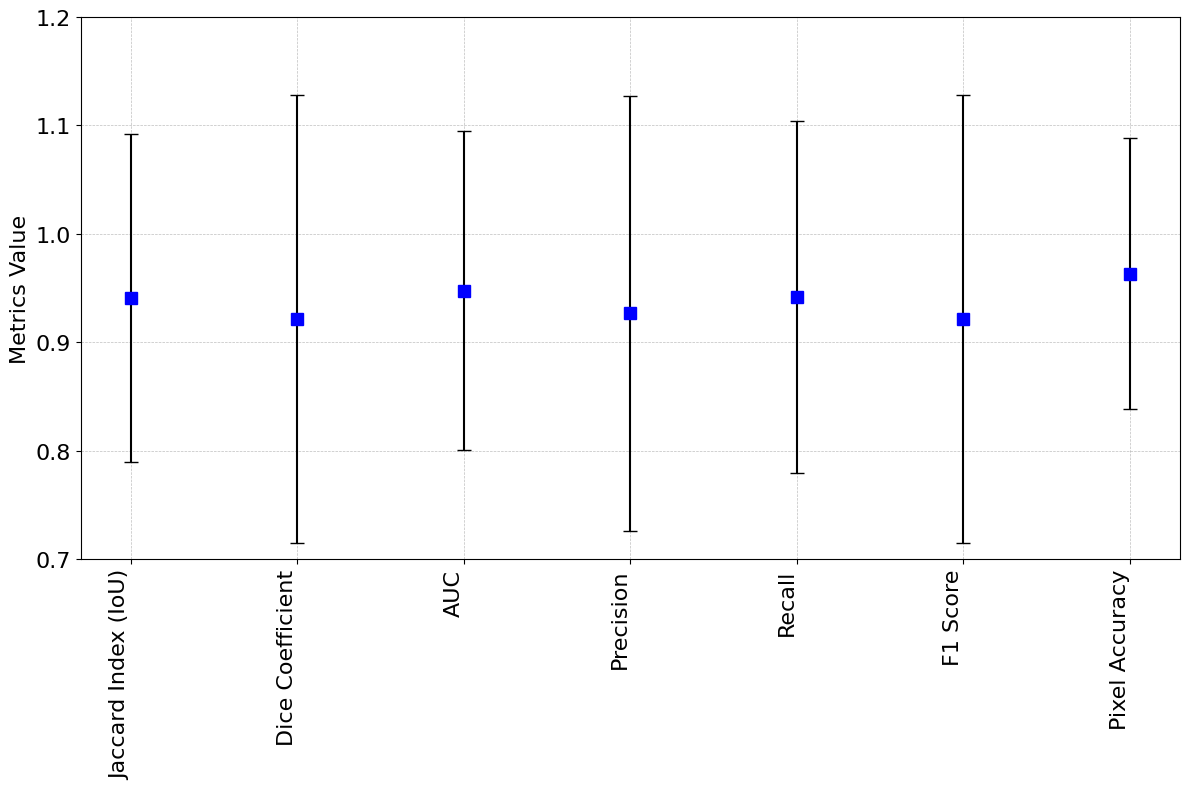

In [91]:
import matplotlib.pyplot as plt

metrics_names = list(mean_metrics.keys())
metrics_values = list(mean_metrics.values())
metrics_std = list(std_metrics.values())

# Define colors for metrics and std
std_color = 'black'
bar_color = 'slategray'
mean_color = 'red'  # Color for the mean square marker

# Define figure size and bar width
plt.figure(figsize=(12, 8))
bar_width = 0.35

# Plot bars for metrics values
#bars = plt.bar(metrics_names, metrics_values, width=bar_width, color=bar_color)

# Plot error bars for standard deviation
plt.errorbar(metrics_names, metrics_values, yerr=metrics_std, fmt='none', ecolor=std_color, capsize=5, label='Standard Deviation')

# Add mean marker as a small square on top of the bars
for i, metric_value in enumerate(metrics_values):
    plt.plot(i, metric_value, marker='s', markersize=8, color="blue")  # Plot only the marker for the mean

# Set legend
# plt.legend(["Mean", "Standard Deviation"], loc='lower center', fontsize=14)

# Set axis labels and ticks
plt.ylabel('Metrics Value', fontsize=16)
plt.xticks(fontsize=16, rotation=90, ha='right')
plt.yticks(fontsize=16)
plt.ylim(0.7, 1.2)
plt.grid(color='grey', linestyle='--', linewidth=0.5, alpha=0.5)

plt.tight_layout()

plt.savefig('mean_metrics_plot.pdf')
plt.show()


In [70]:
import numpy as np
import os
import matplotlib.pyplot as plt

# Directories
images_dir = '/home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/images/'
annotations_dir = '/home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/labels_seg/'

# Lists to store metrics for all images
iou_list = []
dice_list = []
auc_list = []
jaccard_list = []
precision_list = []
recall_list = []
f1_list = []
pixel_accuracy_list = []

# List image files
image_files = os.listdir(images_dir)
image_files.sort()  # Sorting for consistency

# List annotation files
annotation_files = os.listdir(annotations_dir)
annotation_files.sort()  # Sorting for consistency

# Ensure both directories have the same number of files
assert len(image_files) == len(annotation_files), "Number of images and annotations do not match"

# Iterate over each image and annotation file
for image_file, annotation_file in zip(image_files, annotation_files):
    # Image and annotation paths
    image_path = os.path.join(images_dir, image_file)
    annotation_path = os.path.join(annotations_dir, annotation_file)
    
    # Create masks
    ground_truth_mask, combined_mask = create_masks(image_path, annotation_path)
    
    # Calculate metrics
    metrics = calculate_metrics(ground_truth_mask, combined_mask)
    
    iou_list.append(metrics["Jaccard Index (IoU)"])
    dice_list.append(metrics["Dice Coefficient"])
    auc_list.append(metrics["AUC"])
    precision_list.append(metrics["Precision"])
    recall_list.append(metrics["Recall"])
    f1_list.append(metrics["F1 Score"])
    pixel_accuracy_list.append(metrics["Pixel Accuracy"])

# Calculate Mean and Standard Deviation
mean_metrics = {
    "Jaccard Index (IoU)": np.mean(iou_list),
    "Dice Coefficient": np.mean(dice_list),
    "AUC": np.mean(auc_list),
    "Precision": np.mean(precision_list),
    "Recall": np.mean(recall_list),
    "F1 Score": np.mean(f1_list),
    "Pixel Accuracy": np.mean(pixel_accuracy_list),
}
std_metrics = {
    "Jaccard Index (IoU)": np.std(iou_list),
    "Dice Coefficient": np.std(dice_list),
    "AUC": np.std(auc_list),
    "Precision": np.std(precision_list),
    "Recall": np.std(recall_list),
    "F1 Score": np.std(f1_list),
    "Pixel Accuracy": np.std(pixel_accuracy_list),
}

# Calculate Median Absolute Deviation (MAD)
mad_metrics = {
    "Jaccard Index (IoU)": np.median(np.abs(iou_list - np.median(iou_list))),
    "Dice Coefficient": np.median(np.abs(dice_list - np.median(dice_list))),
    "AUC": np.median(np.abs(auc_list - np.median(auc_list))),
    "Precision": np.median(np.abs(precision_list - np.median(precision_list))),
    "Recall": np.median(np.abs(recall_list - np.median(recall_list))),
    "F1 Score": np.median(np.abs(f1_list - np.median(f1_list))),
    "Pixel Accuracy": np.median(np.abs(pixel_accuracy_list - np.median(pixel_accuracy_list))),
}

print("Overall Mean Metrics:")
for metric, value in mean_metrics.items():
    print(metric + ":", value)

print("\nOverall Standard Deviation Metrics:")
for metric, value in std_metrics.items():
    print(metric + ":", value)

print("\nOverall Median Absolute Deviation Metrics:")
for metric, value in mad_metrics.items():
    print(metric + ":", value)



image 1/1 /home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/images/1706981199297.jpg: 480x640 1 bottle, 2 cups, 14.5ms
Speed: 12.4ms preprocess, 14.5ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 9 objects, 10.3ms
Speed: 1.6ms preprocess, 10.3ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/images/1706981219314.jpg: 480x640 1 bottle, 1 computer, 2 cups, 5.9ms
Speed: 1.0ms preprocess, 5.9ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 17 objects, 6.9ms
Speed: 0.8ms preprocess, 6.9ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /home/saf/Documents/workspace/FusionVision/quantitative_eval/valid/images/1706981222961.jpg: 480x640 1 bottle, 1 computer, 1 cup, 6.9ms
Speed: 1.0ms preprocess, 6.9ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 640)

0: 480x640 10 objects, 7

Overall Mean Metrics:
Jaccard Index (IoU): 0.9410598348810999
Dice Coefficient: 0.9211421304541294
AUC: 0.9476630056537722
Precision: 0.9265890517613802
Recall: 0.9413302996039452
F1 Score: 0.9211421304541295
Pixel Accuracy: 0.9631814236111111

Overall Standard Deviation Metrics:
Jaccard Index (IoU): 0.15118854377838037
Dice Coefficient: 0.20665699147176567
AUC: 0.1472463805798814
Precision: 0.20098871199555549
Recall: 0.16240698792314595
F1 Score: 0.20665699147176567
Pixel Accuracy: 0.1252274077432293

Overall Median Absolute Deviation Metrics:
Jaccard Index (IoU): 0.00820392156862737
Dice Coefficient: 0.005576175651965554
AUC: 0.0026649988566522786
Precision: 0.007004538539085892
Recall: 0.009730117857756904
F1 Score: 0.005576175651965665
Pixel Accuracy: 0.0029361979166666607


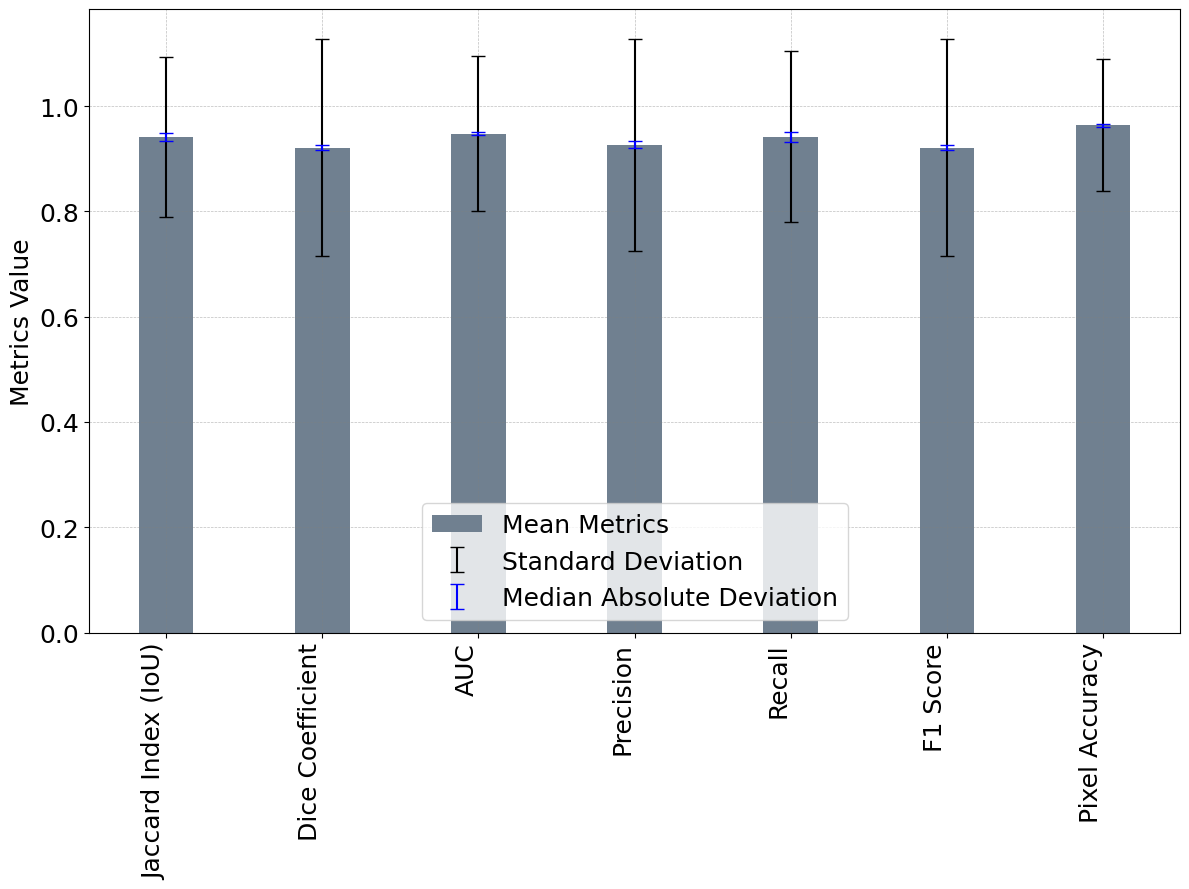

In [79]:
# Define colors for metrics and std
std_color = 'black'
bar_color = 'slategray'
mean_color = 'red'  # Color for the mean square marker

# Define figure size and bar width
plt.figure(figsize=(12, 9))
bar_width = 0.35

# Plot bars for metrics values
bars = plt.bar(mean_metrics.keys(), mean_metrics.values(), width=bar_width, color=bar_color, label='Mean Metrics')

# Plot error bars for standard deviation
plt.errorbar(mean_metrics.keys(), mean_metrics.values(), yerr=list(std_metrics.values()), fmt='none', ecolor=std_color, capsize=5, label='Standard Deviation')

# Plot Median Absolute Deviation (MAD)
plt.errorbar(mean_metrics.keys(), mean_metrics.values(), yerr=list(mad_metrics.values()), fmt='none', ecolor='blue', capsize=5, label='Median Absolute Deviation')

# Add legend
plt.legend(fontsize=18, loc='lower center')

# Set axis labels and ticks
plt.ylabel('Metrics Value', fontsize=18)
plt.xticks(fontsize=18, rotation=90, ha='right')
plt.yticks(fontsize=18)

plt.grid(color='grey', linestyle='--', linewidth=0.5, alpha=0.5)

plt.tight_layout()

plt.savefig('mean_metrics_plot.pdf')
plt.show()